In [ ]:
# Names: Max Collins, Marwan Bit, Nikolas Hall
# Physics 24A
# Prof. Saeta
# Final Project: Gravity Assist "Slingshot" Maneuver

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from p24asolver import P24ASolver

# Constants we'll need:
JUPR = 10.0  # Radius of Jupiter's orbit
JUPω = 2.0   # Angular speed of Jupiter's orbit
JUPM = 10.0  # Mass of Jupiter
SUNM = 100.0 # Mass of the Sun
SATM = 1.0   # Mass of the satellite


fpsq = 4 * (np.pi)**2 # Four pi-squared
G = fpsq              # G with units of AU, solar masses

In [2]:
def sun_fall(t, Y, *args):
    return Y[0]**2 + Y[2]**2
sun_fall.terminal = True

In [48]:


class Planet(P24ASolver):
    """Allows us to create objects that represent the Sun and the planets."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
#         super().__init__(
#             (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
#              ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
#         )
        
        # Now store variables, using defaults, if necessary
        self.mass = kwargs.get('m', 1.0)        # Mass, in solar masses
        self.radius = kwargs.get('r', 0.00047)  # Planetary radius, in AU (default is for Jupiter)
        self.rorbit = kwargs.get('ro', 1.0)     # Orbital radius, in AU (assumes perfectly circular orbits)
        self.period = np.sqrt(((self.rorbit)**3) / (self.mass + 1))     # Period of orbit determined by other parameters
                                                                        # Units are AU, years, and solar masses
        
        self.ω = 0
        if self.period != 0:
            self.ω = (2 * np.pi) / self.period
        
        self.color = kwargs.get('c', "b")   # Planet's color in the animation (blue by default)
    
    def __str__(self):
        "Produces a string representation of the planet's parameters."
        string = "Mass: " + str(self.mass) + "  Radius: " + str(self.radius) + "  Radius of Orbit: " + str(self.rorbit) + "  Period: " + str(self.period)
        return str(string)
        # Add units, and figure out how to get each attribute onto a new line.
    
    def orbit(self, R, ω, t, t_off):
        """
        Arguments: R is the radius of orbit of a planet, ω is its angular speed, and t is the time of interest.
        Returns: Cartesian coordinates for position of the planet at time t.
        """
        return (R * np.math.cos(ω * (t + t_off)), R * np.math.sin(ω * (t + t_off)))
   

 # Planets for a default simulation
SUN = Planet(m = 1.0, r = 0.5, ro = 0.0, c = "y")        # Figure out solar radius (AU) and Jupiter's mass (solar masses)
JUP = Planet(m = 0.00095, r = 0.2, ro = 5.2, c = "g")
    
    
class Satellite(P24ASolver):
    """Allows us to define an object representing our space probe. Simulates a solar system of planets with perfectly circular orbits."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        super().__init__(
            (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
             ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
        )
        # Now store variables, using defaults, if necessary
        self.position = kwargs.get('r', (-1, 0))    # Satellite's position in Cartesian coordinates
                                                    # Default is x = -1 AU y = 0 AU
            
        self.velocity = kwargs.get('v', (0, 0))     # Satellite's velocity in the x- and y-directions
                                                    # Default is satellite at rest
        
        self.planets = kwargs.get('p', [SUN, JUP])  # A list of the planets that the satellite can interact with
                                                    # By default, includes the Sun and Jupiter

            
        self.events.append(sun_fall)
        
        
        self.time_offset = kwargs.get('t_offset', 0)
        
        
        # We treat the satellite as though it has negligible mass and no radius
        # The satellite is a point moving through space
        
        
    def __str__(self):
        "Produces a string representation of a satellite."
        string = "Position: (x, y) = " + str(self.position) + "  Velocity: (vx, vy) = " + str(self.velocity)
        return str(string)
        
        
    def derivatives(self, t, Y):
        """ Accepts: Time of interest, derivatives vector, and """
        x1, v1, x2, v2 = Y  # Unpack the values
                            # x1 = x-position, v1 = x-velocity
                            # x2 = y-position, v2 = y-velocity
        
        self.position = (x1, x2)    # Update the satellite's position
                                    # Could also update velocity if necessary
        
        Alist = []
        
        for planet in self.planets:          # For each planet in the simulation...
            
            xp1, xp2 = planet.orbit(planet.rorbit, planet.ω, t, self.time_offset)    # Get the planet's cartesian position
            
            r_sq = (x1 - xp1)**2 + (x2 - xp2)**2   # Square of the satellite's distance from the current planet
            
            x = xp1 - x1
            y = xp2 - x2
            
            cosine_theta = y / np.sqrt(r_sq)
            
            sine_theta = x / np.sqrt(r_sq)

            
            # Get the components of the satellite's gravitational acceleration due to this planet
            a1 = float((G * planet.mass) / r_sq) * sine_theta
            a2 = float((G * planet.mass) / r_sq) * cosine_theta
            
            # Add those components to a list of accelerations
            Alist += [[a1, a2]]
            
        A1 = 0   # Total acceleration in the x-direction
        A2 = 0   # Total acceleration in the y-direction
        
        # Sum components to get the total x- and y-accelerations
        for a in Alist:
            A1 += a[0]
            A2 += a[1]
        
        return [v1, A1, v2, A2]   # Return a time derivative of Y

    
    def prepare_figure(self):
        """
        Function that creates the figure and axes for the animation.
        """

        fig, ax = plt.subplots(figsize = (10, 10))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        ax.set_xlim((-6, 6))
        ax.set_ylim((-6, 6))
        
        # Add satellite to the list of shapes in the animation
        self.shapes = [Circle((self.position), radius = 0.05, color = 'r')]
        
        for planet in self.planets:
            self.shapes.append(Circle(planet.orbit(planet.rorbit, planet.ω, 0, self.time_offset), radius = planet.radius, color = planet.color))
        
        
        # ****Figure out how to add unfilled circles representing the orbits*****
        
        for s in self.shapes:
            ax.add_patch(s)
            
        return fig, ax

    
    def draw_frame(self, t):
        """
        Draw frame for time t
        """

        x1, v1, x2, v2 = self.solution.sol(t)
        
        # First, we remove existing shapes from self.shapes
        for n in range(len(self.shapes) - 1, -1, -1):
            self.shapes[n].remove()
        
        # Add the satellite back in
        self.shapes = [Circle((x1, x2), radius = 0.05, color = 'r')]

        # Draw the planets at their new positions, obtained using the orbit() function
        for planet in self.planets:
            p = Circle(planet.orbit(planet.rorbit, planet.ω, t, self.time_offset), radius = planet.radius, color = planet.color)
            self.shapes.append(p)
            #self.shapes.append(p)
        
        for s in self.shapes:
            self._ax.add_patch(s)

        # title = self._ax.set_title(f"t = {t:.2f}", usetex=False)

        # By returning the list of Artists that have changed,
        # we speed up the animation
        return self.shapes  # Might need to return a tuple (see P24A Solver)
    
    
    def distance(self, solution, planet, t):
        xp, yp = planet.orbit(planet.rorbit, planet.ω, t, self.time_offset)
        x1, v1, x2, v2 = solution(t)
        x_dist = x1 - xp
        y_dist = x2 - yp
        return np.sqrt(x_dist**2 + y_dist**2)
    
    def energy(self, solution, t):
        """
        Returns the satellite's total energy divided by its mass.
        """
        x1, v1, x2, v2 = solution(t)
        
        K = 0.5 * (v1**2 + v2**2)
    
        U = 0
    
        for planet in self.planets:
            dist = self.distance(solution, planet, t)
            U += (G * planet.mass) / dist
    
        return K + U

In [32]:
# *** See energy function above ***
def KE(t, solution):
    """
    Returns the kinetic energy of the satellite at time t for the given solution.
    """
    return 0.5 * SATM * (solution(t)[1]**2 + solution(t)[3]**2)


# Original pathfinder function
def path_finder(max_vel, max_vel_steps, approach_dist):
    """
    input: max_vel is the maximum total velocity, sol is a solved satellite
    """
    launches = []
    times = np.linspace(0,5,1825)
    count = 0
    give_up_count = 0
    ##### To start we'll pick a date to launch at. since jupiter has a 12 year orbit, we'll allow any day of that orbit for launch #####
    for offset in np.linspace(0,12,1100):
        count += 1
        print(count)
        if give_up_count == 1100*10:
            return launches
    ##### next we need to determine the speed we'll launch at #######
        for x_vel in np.linspace(0, max_vel, max_vel_steps):
            y_vel = np.sqrt(max_vel**2 - x_vel**2)
            
    ##### we launch from the earth ###################################
            init_pos = (1,x_vel,0,y_vel)
            sol = Satellite(t_off = offset).solve(init_pos,(0,5))
            
    ##### first we check that the satellite reaches a point where it's reasonably close to Jupiter ####
            jup_radii = [np.sqrt((JUP.orbit(JUP.rorbit,JUP.ω, t,offset)[0] -sol(t)[0])**2+(JUP.orbit(JUP.rorbit,JUP.ω, t,offset)[1]-sol(t)[2])**2) for t in times]
            if min(jup_radii) < approach_dist and min(jup_radii) > 0.0004673296:
                    give_up_count = 0
                    print('succesful approach at offset:', offset, 'x_vel:', x_vel, 'y_vel:',y_vel)
                    
                    ##### now we look for an increase in velocity #############
                    velocities = [np.sqrt(sol(t)[1]**2+sol(t)[3]**2) for t in times]
                    if max(velocities) > max_vel:
                        print('succesful launch at offset:', offset, 'x_vel:', x_vel, 'y_vel:',y_vel)
                        launches.append((offset, x_vel,y_vel))
    #### if jup
            else:
                give_up_count += 1
    return launches

path_finder(8, 16, 1)

1
succesful approach at offset: 0.0 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.0 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.0 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.0 x_vel: 6.4 y_vel: 4.799999999999999
succesful approach at offset: 0.0 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
succesful launch at offset: 0.0 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
succesful approach at offset: 0.0 x_vel: 7.466666666666667 y_vel: 2.8720878971384014
succesful launch at offset: 0.0 x_vel: 7.466666666666667 y_vel: 2.8720878971384014
2
succesful approach at offset: 0.01091901728844404 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.01091901728844404 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.01091901728844404 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.01091901728844404 x_vel: 6.4 y_vel: 4.

succesful launch at offset: 0.10919017288444041 x_vel: 7.466666666666667 y_vel: 2.8720878971384014
12
succesful approach at offset: 0.12010919017288445 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset: 0.12010919017288445 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful approach at offset: 0.12010919017288445 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.12010919017288445 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.12010919017288445 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.12010919017288445 x_vel: 6.4 y_vel: 4.799999999999999
succesful approach at offset: 0.12010919017288445 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
succesful launch at offset: 0.12010919017288445 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
13
succesful approach at offset: 0.13102820746132848 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset:

KeyboardInterrupt: 

In [60]:
# My attempt at a pathfinder function
def pathfinder(initial_vel, end_time):
    """
    Arguments: initial_vel is the satellite's initial velocity.
               approach_dist is the minimum satellite-planet distance for which the satellite does not crash.
               end_time is the time at which we will compare satellite energies between scenarios.
                   
    Returns:   A launch dictionary of (keys are offset times, entries are energies at t = end_time) and
               the key for the scenario that maximizes energy at end_time.
    """
        
    # Assumptions:
    # 1. Satellite always begins at position (-1, 0) (default, at Earth orbit)
    # 2. Satellite's initial velocity is always directed in the -y direction
    #    (tangent to Earth orbit)
    # 3. For now, satellite has the same initial velocity (which we specify) in all scenarios
        
    # If a slingshot has occurred, the satellite's total energy should have increased.
    # Because total energy will not decrease later, we can compare total energy at end_time
    # for different scenarios. The scenario with the highest total energy at end_time
    # will be the best slingshot scenario.
        
    launches = {}                    # Dictionary of launch scenarios
    times = np.linspace(0, end_time, end_time * 365)  # List of all days from 0 to end_time
        
    # ** Could update this function so that it takes a satellite as an argument,
    # ** tests offset time launch scenarios using that satellite's particular attributes
    # ** (position, initial velocity, etc.)
        
    # Test each possible offset time in the orbital period of Jupiter, with four-day launch increments (1100 in total)
    for offset in np.linspace(0, 12, 1100):
            
        sat = Satellite(v = (0, - initial_vel), t_offset = offset)  # Create a satellite object
            
        scenario = (-1, 0, 0, -initial_vel)  # Set up a launch scenario (tuple is (x1, v1, x2, v2))
            
        solution = sat.solve(scenario, (0, end_time)) # Solve for the satellite's motion on the interval from 0 to end_time
         
        break_out_flag = False
        
        # Check to make sure that the satellite hasn't crashed into a planet
        for planet in sat.planets:
            distances = [sat.distance(solution, planet, t) for t in times]
            closest_approach = min(distances)
            if closest_approach <= planet.radius:
                break_out_flag = True
            
        # If the satellite has crashed, move on to the next scenario
        if break_out_flag == True:
            continue
            
        # If it hasn't crashed, find its total energy at end_time
        energy = sat.energy(solution, end_time)
            
        # Store the total energy in the launches dictionary
        launches[offset] = energy
            
    best_offset = max(launch_dict, key = launch_dict.get) # Gets the key associated with the highest energy
        
    return launches, best_offset  # Return the dictionary of energies and t_offset for the highest energy
            

In [62]:
# Test of energy function
sat = Satellite()
rest = (1, 8.5, 0, 0)
sol1 = sat.solve(rest, (0, 12))
print(sol1)
E_tot = sat.energy(sol1, 1)
print(E_tot)

Position: (x, y) = (7.9948337749890355, 0.03221903705768728)  Velocity: (vx, vy) = (0, 0)
11.605912754890525


In [51]:
# DO NOT RUN THIS AGAIN
# (takes a few minutes)

# Test of pathfinder function
launch_dict, offset = pathfinder(8.4, 5)
print(offset)
# 12 isn't the right offset. Pathfinder was originally returning the largest key,
# not the key for the largest energy.

12.0


In [59]:
max_key = max(launch_dict, key = launch_dict.get)
#print(max_key)
print("Highest energy is " + str(launch_dict[max_key]) + " at t_offset = " + str(max_key))

# print(launch_dict)

Highest energy is 5.5324619029090645 at t_offset = 9.150136487716106


In [8]:
# *** OLDER TESTS OF THE ANIMATION ***

sat = Satellite()
rest = (1, 8.5, 0, 0)
sol1 = sat.solve(rest, (0, 12))
times = np.linspace(0, 12, 100)

<IPython.core.display.Javascript object>


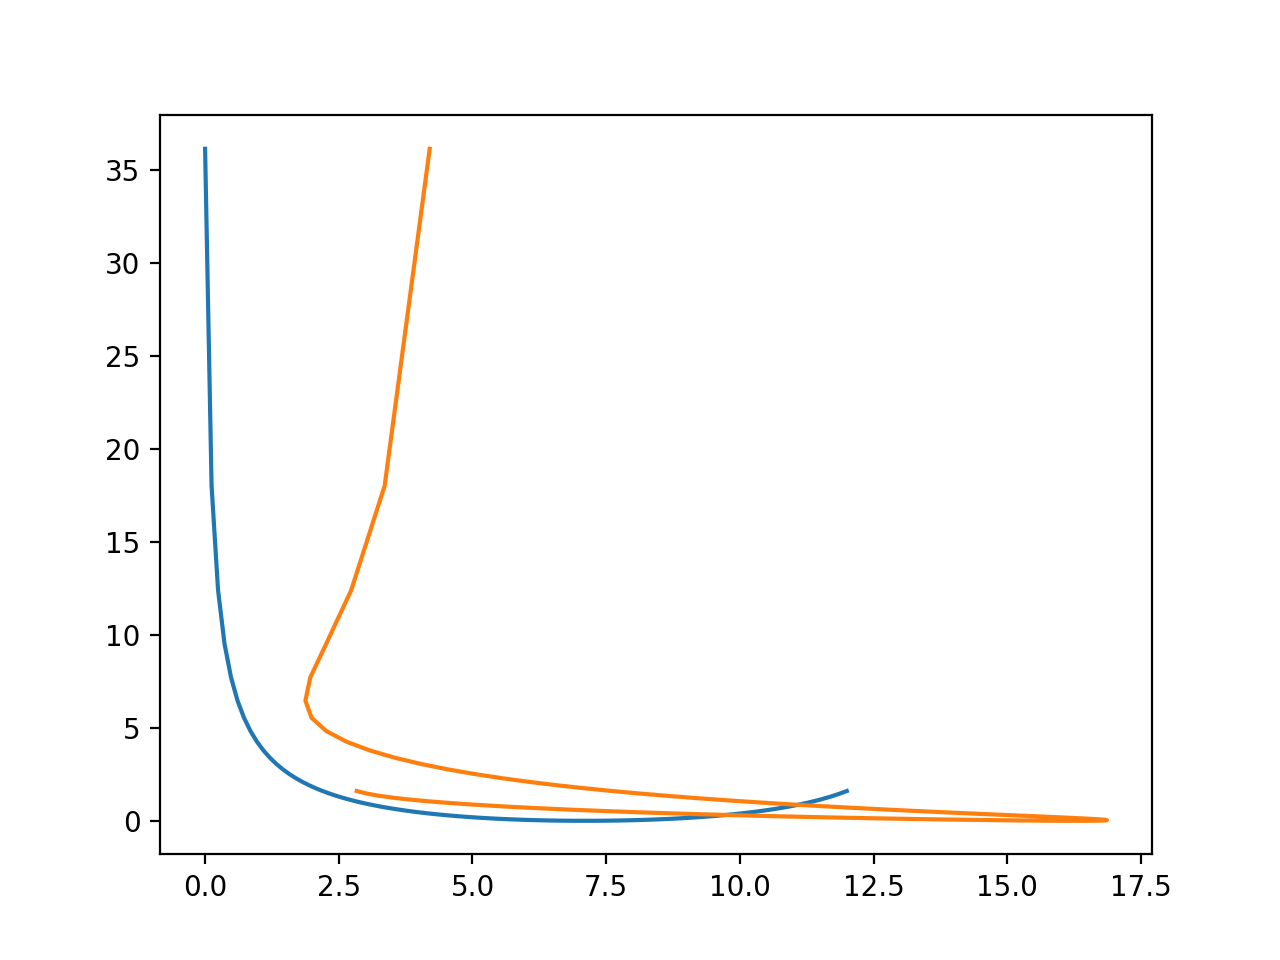

In [9]:
KE_list = [KE(t, sol1) for t in times]
jup_radii = [np.sqrt((JUP.orbit(JUP.rorbit, JUP.ω, t, 0)[0] - sol1(t)[0])**2 + (JUP.orbit(JUP.rorbit, JUP.ω, t, 0)[1] - sol1(t)[2])**2) for t in times]

fig, ax = plt.subplots()
ax.plot(times, KE_list);    # Blue line
ax.plot(jup_radii, KE_list);  # Orange line

<IPython.core.display.Javascript object>


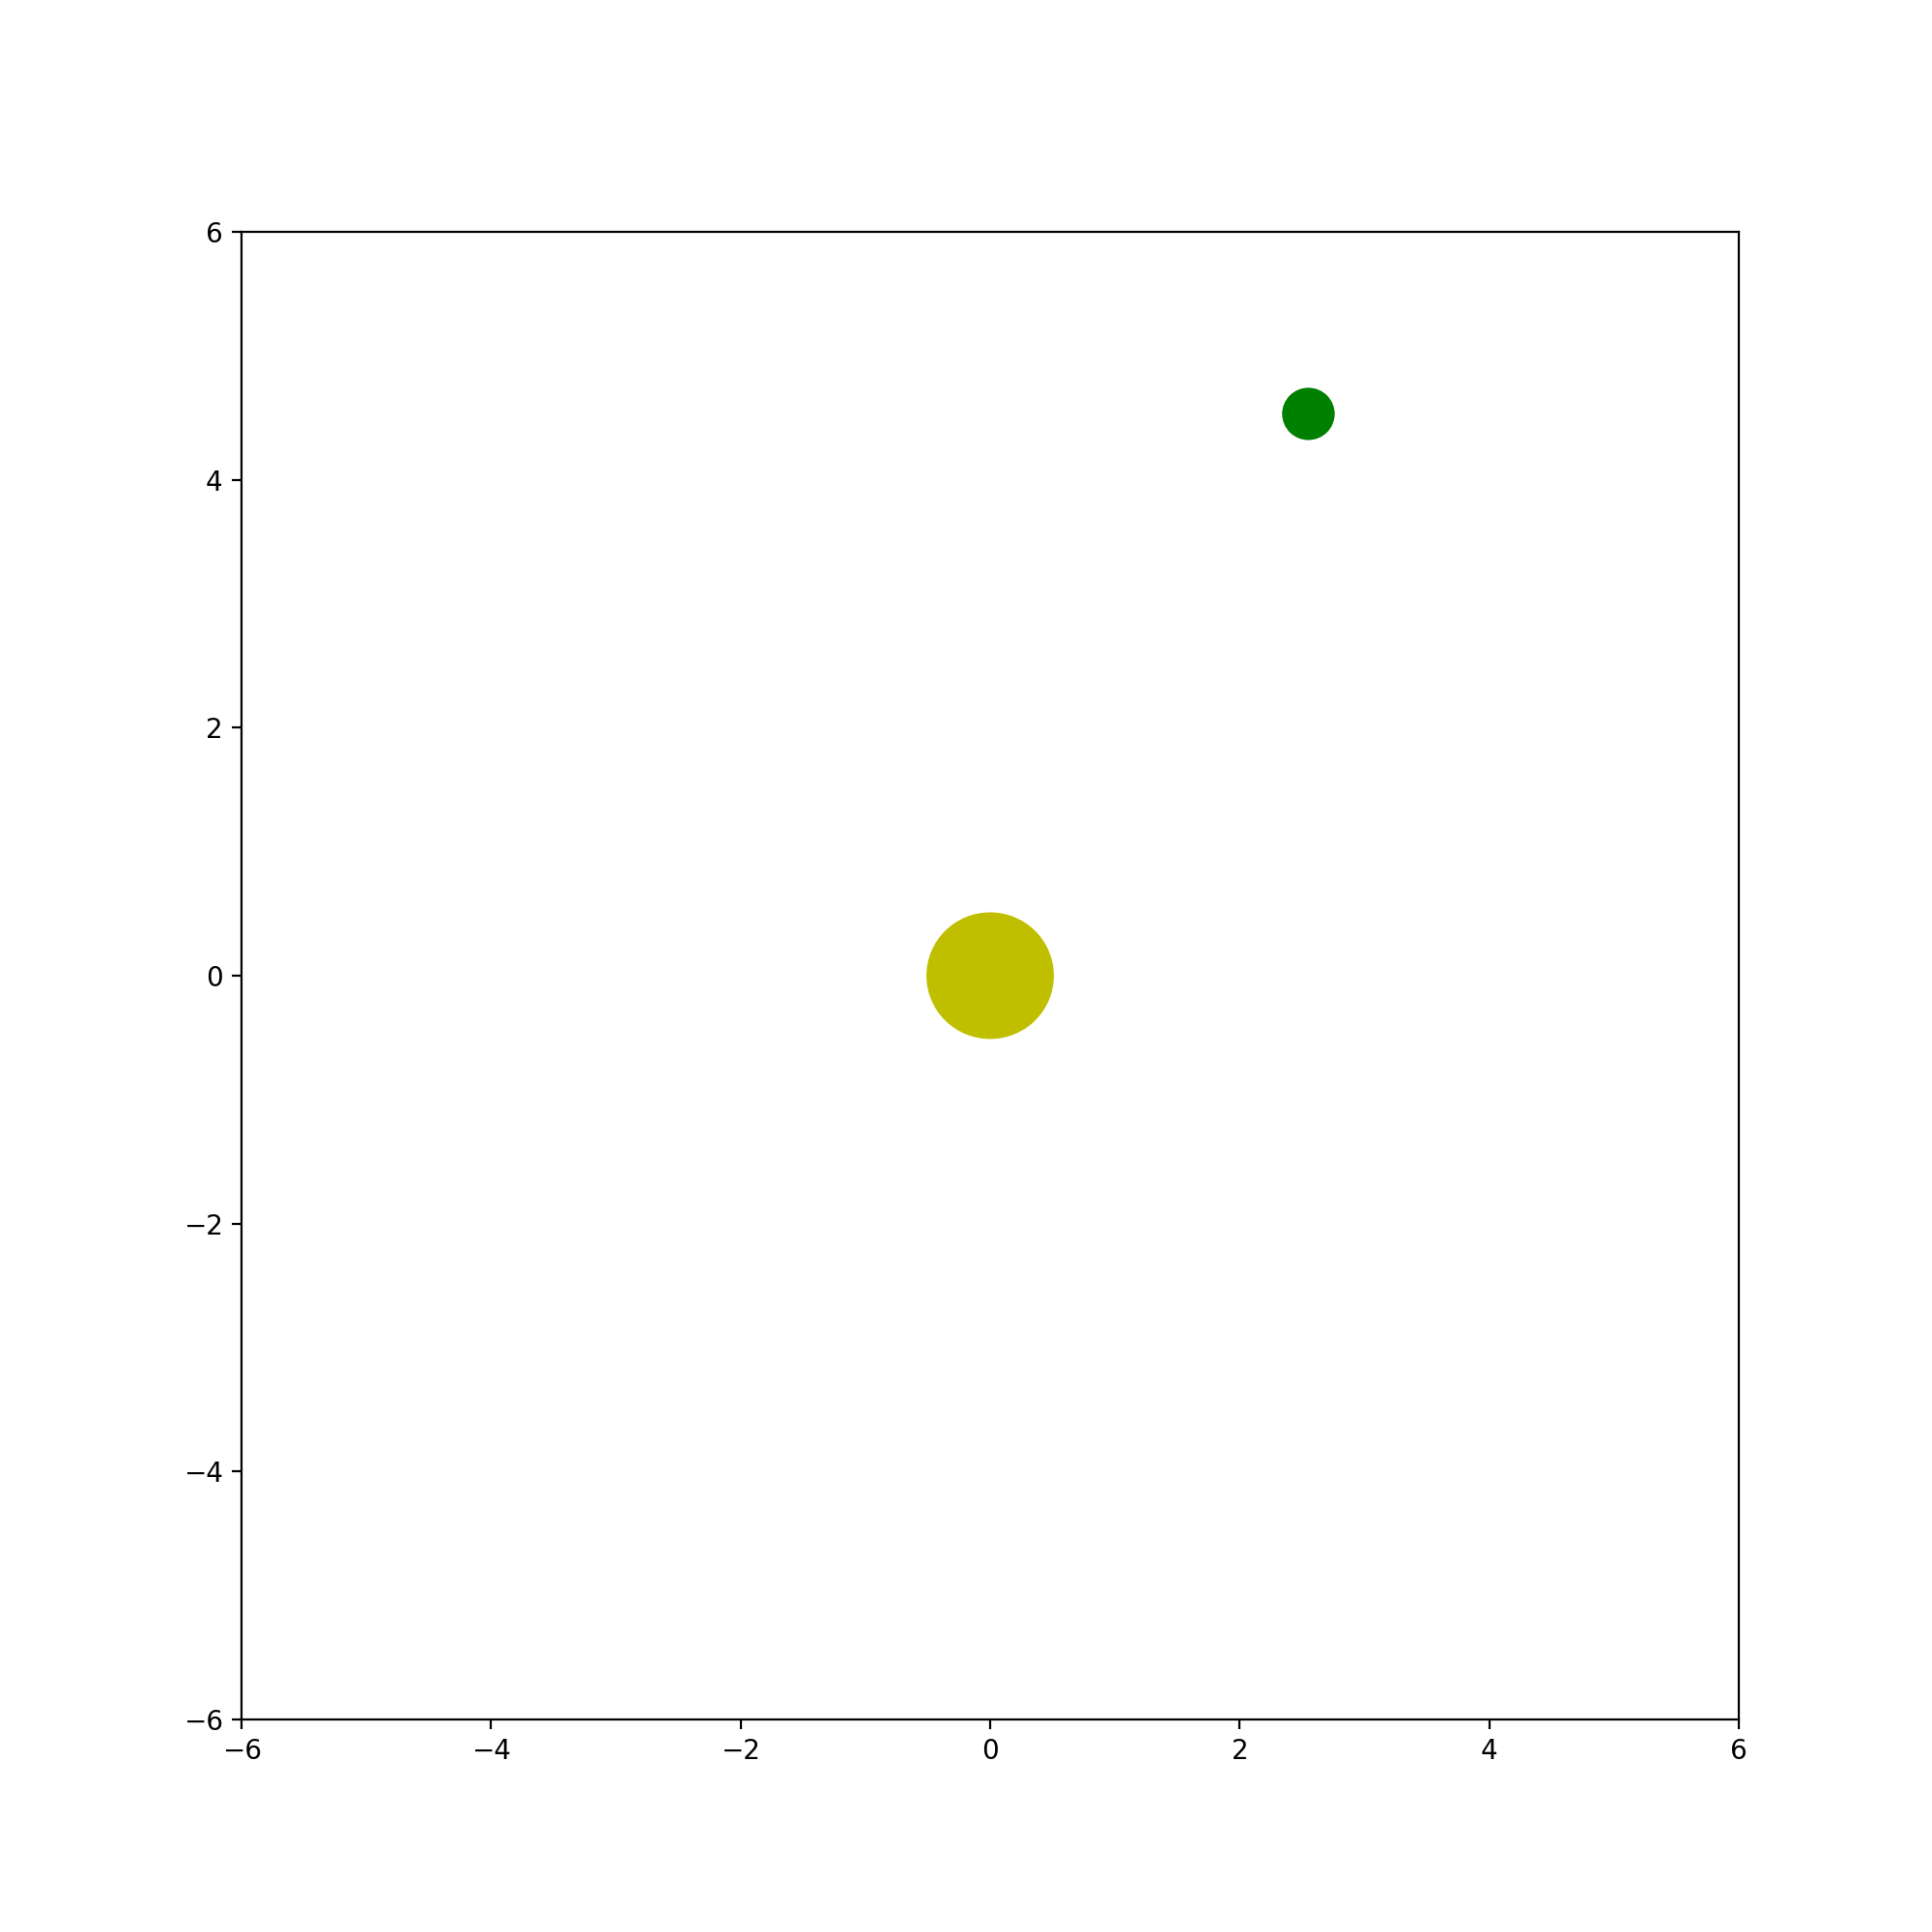

In [11]:
sol1.animate(500);
#print(str(sat.planets[0]) + "; " + str(sat1.planets[1]))
#print(sat1.shapes)